In [1]:
%matplotlib inline
from collections import defaultdict
import pymc as pm
from pymc.Matplot import plot as mcplot
import numpy as np
from matplotlib import pyplot as plt
import json
from pymongo import MongoClient
import pymongo
from bson.objectid import ObjectId
import random

## Data Structure

In [2]:
def random_limit(distribution):
    val = distribution.random()
    while val > 1 or val < 0:
        val = distribution.random()
    return val

class grader(object):
    def __init__(self, name,bias_mean,bias_tau):
        self.name = name
        self.handins = list()
        self.bias_mean = bias_mean
        self.bias_tau = bias_tau
        
    def add_handin(self, handin):
        self.handins.append(handin)
                
    def grade_handins(self):
        for handin in self.handins:
            B = pm.Normal('B_generator',self.bias_mean,self.bias_tau)
            handin.add_gradeing(self,B.random())

class handin:
    def __init__(self,title,owner,true_value,precision):
        self.title = title
        self.owner = owner
        self.gradeings = dict()
        self.graders = list()
        self.true_val = true_value
        self.precision = precision
    
    def add_grader(self,grader):
        self.graders.append(grader)
    
    def add_gradeing(self,grader,bias):
        obs = pm.Normal('obs_generator',self.true_val+bias,self.precision)
        self.gradeings[grader.name] = random_limit(obs)
        
        
class assignment(object):
    
    def __init__(self, handins_input, graders_input):
        self.handins = dict()
        self.graders = dict()
        for handin in handins_input:
            self.handins[handin.title] = handin
        for grader in graders_input:
            self.graders[grader.name] = grader
    
    def add_handin(self, handin):
        self.handing[handin.title] = handin
        
    def add_grader(self, grader):
        self.graders[grader.title] = grader
    
    def find_ungraded_handin(self, grader):
        
        # sort the handins by the one with the least
        sorted_l = sorted(self.handins.values(),key=lambda x: len(x.graders))
        #i = int(random.uniform(0,len(sorted_l)))
        i = 0
        handin = sorted_l[i]
        while handin in grader.handins or (handin.owner.name == grader.name):
        #while(handin.owner.name == grader.name):
            i += 1
            #i = int(random.uniform(0,len(sorted_l)))
            handin = sorted_l[i]
        return handin
            
    def grade_handins(self,n_handins):
        # Distribute handins
        for i in xrange(0,n_handins):
            for grader in self.graders.itervalues():
                h = self.find_ungraded_handin(grader)
                h.add_grader(g)
                grader.add_handin(h)
                
        # grade handins
        for grader in self.graders.itervalues():
            grader.grade_handins()

## Generate Observed Data

In [3]:
T_mu = pm.Normal('T_mu_generator',0.5,25)
T_tau = pm.Gamma('T_tau_generator',10,0.1)
B_mu = pm.Normal('B_mu_generator',0,100)
B_tau = pm.Gamma('B_tau_generator',50,0.1)

handins_data = list()
graders_data = list()

for i in xrange(0,20):
    g = grader('grader_%i' % i,B_mu.random(),B_tau.random())
    t_mu = random_limit(T_mu)
    h = handin('handin_%i' % i, g, t_mu, T_tau.random())
    graders_data.append(g)
    handins_data.append(h)
    
assignment_data_true = assignment(handins_data,graders_data)
assignment_data_true.grade_handins(10)

In [5]:
T_mu = pm.Normal('T_mu_generator',0.5,25)
T_tau = pm.Gamma('T_tau_generator',10,0.1)
B_mu = pm.Normal('B_mu_generator',0,100)
B_tau = pm.Gamma('B_tau_generator',50,0.1)

handins_data = list()

for i in xrange(20,40):
    t_mu = random_limit(T_mu)
    h = handin('handin_%i' % i, graders_data[i-20], t_mu, T_tau.random())
    handins_data.append(h)
    
assignment_data_2 = assignment(handins_data,graders_data)
assignment_data_2.grade_handins(10)

In [6]:
T_mu = pm.Normal('T_mu_generator',0.5,25)
T_tau = pm.Gamma('T_tau_generator',10,0.1)
B_mu = pm.Normal('B_mu_generator',0,100)
B_tau = pm.Gamma('B_tau_generator',50,0.1)

handins_data = list()

for i in xrange(40,60):
    t_mu = random_limit(T_mu)
    h = handin('handin_%i' % i, graders_data[i-60], t_mu, T_tau.random())
    handins_data.append(h)
    
assignment_data_3 = assignment(handins_data,graders_data)
assignment_data_3.grade_handins(10)

## Models

In [8]:
def execute_model(model):
    mcmc = pm.MCMC(model)
    mcmc.sample(10000)
    return mcmc

In [9]:
def handin_model_1(data):
    N_H = len(data)
    
    # Bias
    T = dict()
    B = dict()
    B_mu = dict()
    B_tau = dict()
    O = list()

    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        
        N_G = len(scores)
        T_mu = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T[h_id] = pm.Normal('T_%s' % str(h_id), mu=T_mu, tau=100)
        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            
            if g_id not in B:
                if g_id not in B_mu:
                    B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,100)
                if g_id not in B_tau:
                    B_tau[g_id] = pm.Gamma('B_tau_%s' % str(g_id), 50, 0.1)
                B[g_id] = pm.Normal('B_%s' % str(g_id), mu=B_mu[g_id], tau=B_tau[g_id])
            O.append(pm.Normal('O_%(h)i_%(g)i' % {'h': h, 'g':g}, mu = T[h_id] + B[g_id], tau=100, observed=True, value=val))
        
            
    collection = [pm.Container(T),
                  pm.Container(O),
                  pm.Container(B)]
    
    model = pm.Model(collection)
    map_ = pm.MAP(model)
    map_.fit()
    return model

In [10]:
def handin_model_2(data):
    N_H = len(data)
    
    # Bias
    T = dict()
    T_mu = dict()
    T_tau = dict()
    B = dict()
    B_mu = dict()
    B_tau = dict()
    O = list()

    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        
        N_G = len(scores)
        T_mu[h_id] = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T_tau[h_id] = pm.Gamma('T_tau_%s' % str(h_id),10,0.1)
        T[h_id] = pm.Normal('T_%s' % str(h_id), mu=T_mu[h_id], tau=T_tau[h_id])

        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            
            if g_id not in B:
                if g_id not in B_mu:
                    B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,100)
                if g_id not in B_tau:
                    B_tau[g_id] = pm.Gamma('B_tau_%s' % str(g_id), 50, 0.1)
                B[g_id] = pm.Normal('B_%s' % str(g_id), mu=B_mu[g_id], tau=B_tau[g_id])
            O.append(pm.Normal('O_%(h)i_%(g)i' % {'h': h, 'g':g}, mu = T[h_id] + B[g_id], tau=100, observed=True, value=val))
        
            
    collection = [pm.Container(T),
                  pm.Container(T_mu),
                  pm.Container(T_tau),
                  pm.Container(O),
                  pm.Container(B_mu),
                  pm.Container(B_tau)]
    
    model = pm.Model(collection)
    mcmc = pm.MCMC(model)
    mcmc.sample(10000,burn=2000)
    return 

In [109]:
def handin_model_3(data):
    N_H = len(data)
    
    # Bias
    T_mu = dict()
    T_tau = dict()
    B_mu = dict()
    B_tau = dict()
    
    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        
        N_G = len(scores)
        lambda_t = pm.Uniform('lambda_t_%s' % str(h_id),0.001,50)    
        T_tau[h_id] = pm.Gamma('T_tau_%s' % str(h_id),10,0.1)
        T_mu[h_id] = pm.Normal('T_mu_%s' % str(h_id),0.5,lambda_t*T_tau[h_id])

        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            
            if g_id not in B_mu and g_id not in B_tau:
                lambda_b = pm.Uniform('lambda_b_%s' % str(g_id),0.001,50)    
                B_tau[g_id] = pm.Gamma('B_tau_%s' % str(g_id), 50, 0.1)
                B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,lambda_b*B_tau[g_id])

            @pm.observed
            def Obs(value=val, B_mu=B_mu[g_id], B_tau=B_tau[g_id], T_mu=T_mu[h_id], T_tau=T_tau[h_id]):
                return pm.normal_like(value, B_mu+T_mu, B_tau+T_tau)
                               
    collection = [pm.Container(T_mu),
                  pm.Container(T_tau),
                  pm.Container(B_mu),
                  pm.Container(B_tau)]
    
    model = pm.Model(collection)
    map_ = pm.MAP(model)
    map_.fit()
    return model

In [66]:
def handin_model_4(data):
    N_H = len(data)
    
    # Bias
    T_mu = dict()
    T_tau = dict()
    B_mu = dict()
    B_tau = dict()
    
    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        
        N_G = len(scores)
        T_mu[h_id] = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            
            if g_id not in B_mu:
                B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,100)
                
            @pm.observed
            def Obs(value=val, B_mu=B_mu[g_id], T_mu=T_mu[h_id]):
                return pm.normal_like(value, B_mu+T_mu, 100)
                               
    collection = [pm.Container(T_mu),
                  pm.Container(T_tau),
                  pm.Container(B_mu),
                  pm.Container(B_tau)]
    
    model = pm.Model(collection)
    map_ = pm.MAP(model)
    map_.fit()
    return model

In [69]:
def handin_model_5(data):
    N_H = len(data)
    
    # Bias
    T_mu = dict()
    B_mu = dict()
    O = list()

    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        
        N_G = len(scores)
#        T_mu = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T_mu[h_id] = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            
            if g_id not in B_mu:
                B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,100)
#                B[g_id] = pm.Normal('B_%s' % str(g_id), mu=0, tau=500)
                
            O.append(pm.Normal('O_%(h)i_%(g)i' % {'h': h, 'g':g}, mu = T_mu[h_id] + B_mu[g_id], tau=100, observed=True, value=val))
            
    collection = [pm.Container(T_mu),
                  pm.Container(O),
                  pm.Container(B_mu)]
    
    model = pm.Model(collection)
    map_ = pm.MAP(model)
    map_.fit()
    return model

In [60]:
def handin_model_7(data):
    N_H = len(data)
    
    # Bias
    T_mu = dict()
    T_tau = dict()
    B_mu = dict()
    B_tau = dict()
    
    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        
        N_G = len(scores)
        T_mu[h_id] = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T_tau[h_id] = pm.Gamma('T_tau_%s' % str(h_id),10,0.1)
        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            
            if g_id not in B_mu:
                B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,100)
            if g_id not in B_tau:
                B_tau[g_id] = pm.Gamma('B_tau_%s' % str(g_id), 50, 0.1)

            @pm.observed
            def Obs(value=val, B_mu=B_mu[g_id], B_tau=B_tau[g_id], T_mu=T_mu[h_id], T_tau=T_tau[h_id]):
                return pm.normal_like(value, B_mu+T_mu, B_tau+T_tau)
                               
    collection = [pm.Container(T_mu),
                  pm.Container(T_tau),
                  pm.Container(B_mu),
                  pm.Container(B_tau)]
    
    model = pm.Model(collection)
    return model


In [140]:
def handin_model_Oles(data):
    N_H = len(data)
    
    # Bias
    T_mu = dict()
    T_tau = dict()
    B_mu = dict()
    B_tau = dict()
    O = list()
    
    e = pm.Gamma('error',10,0.1)
    
    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        
        N_G = len(scores)
        T_mu[h_id] = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T_tau[h_id] = pm.Gamma('T_tau_%s' % str(h_id),10,0.1)
        T[g_id] = pm.normal('T_%s' % str(h_id), T_mu, T_tau)        
        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            
            if g_id not in B_mu:
                B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,100)
                B_tau[g_id] = pm.Gamma('B_tau_%s' % str(g_id), 50, 0.1)
                B[g_id] = pm.normal('B_%s' % str(g_id), B_mu, B_tau)
            O.append(pm.Normal('O_%(h)i_%(g)i' % {'h': h, 'g':g}, mu = T[h_id] + B[g_id], tau=e, observed=True, value=val))
                               
    collection = [pm.Container(T_mu),
                  pm.Container(B_mu),
                  pm.Container(O),
                  e]
    
    model = pm.Model(collection)
    return model


In [74]:
def handin_model_6(data):
    N_H = len(data)
    
    # Bias
    T_tau = dict()
    T_mu = dict()
    B_mu = dict()
    B_tau = dict()
    O = list()

    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        
        N_G = len(scores)
        T_mu[h_id] = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T_tau[h_id] = pm.Gamma('T_tau_%s' % str(h_id),10,0.1)
        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            
            if g_id not in B_mu:
                B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,100)
            if g_id not in B_tau:
                B_tau[g_id] = pm.Gamma('B_tau_%s' % str(g_id), 50, 0.1)
                
            O.append(pm.Normal('O_%(h)i_%(g)i' % {'h': h, 'g':g}, mu = T_mu[h_id] + B_mu[g_id], tau=T_tau[h_id] + B_tau[g_id], observed=True, value=val))
               
    collection = [pm.Container(T_mu),
                  pm.Container(T_tau),
                  pm.Container(B_mu),
                  pm.Container(B_tau),
                  pm.Container(O)]
    
    model = pm.Model(collection)
#    map_ = pm.MAP(model)
#    map_.fit()
    return model


In [126]:
def analytic(data):
    N_H = len(data)

    y_h = 1
    lambda_h = 1
    alpha_h = 10
    beta_h = 0.1
    
    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        N_G = len(scores)
        val = map(lambda x: x[1],scores[g])
        mean_h = np.mean(val)
        var_h = np.mean(val) 

        alpha = 1/2+alpha_h
        beta = beta_h+lambda_h*N_G*var_h/2+lambda_h*N_G*(mean_h-y_h)**2/(lambda_h*N_G+1)
        lambda_ =lambda_h*N_G+1
        y = ((mean_h+lambda_h*y_h*N_G)/(lambda_h+1))
        print h_id
        print y, lambda_,alpha,beta
        
        break

In [127]:
analytic(values)

TypeError: list indices must be integers, not grader

In [17]:
def run_3_iteration(model_,values):
    model_back = model_(values)
    mcmc_back_1 = execute_model(model_back)
    return [mcmc_back_1]

In [ ]:
values = assignment_data_true.handins.values()
#values.extend(assignment_data_2.handins.values())
#values.extend(assignment_data_3.handins.values())
mcmc_1 = run_3_iteration(handin_model_1,values)

In [49]:
values = assignment_data_true.handins.values()
#values.extend(assignment_data_2.handins.values())
#values.extend(assignment_data_3.handins.values())
mcmc_2 = run_3_iteration(handin_model_2,values)

 [-----------------100%-----------------] 10000 of 10000 complete in 169.8 sec

/Library/Python/2.7/site-packages/pymc/Model.py:94: UserWarning: The MCMC() syntax is deprecated. Please pass in nodes explicitly via M = MCMC(input).
  'The MCMC() syntax is deprecated. Please pass in nodes explicitly via M = MCMC(input).')


In [110]:
values = assignment_data_true.handins.values()
#values.extend(assignment_data_2.handins.values())
#values.extend(assignment_data_3.handins.values())
mcmc_3 = run_3_iteration(handin_model_3,values)

 [-----------------100%-----------------] 10000 of 10000 complete in 229.9 sec

In [67]:
values = assignment_data_true.handins.values()
#values.extend(assignment_data_2.handins.values())
#values.extend(assignment_data_3.handins.values())
mcmc_4 = run_3_iteration(handin_model_4,values)

 [-----------------100%-----------------] 10000 of 10000 complete in 105.3 sec

In [70]:
values = assignment_data_true.handins.values()
#values.extend(assignment_data_2.handins.values())
#values.extend(assignment_data_3.handins.values())
mcmc_5 = run_3_iteration(handin_model_5,values)

 [-----------------100%-----------------] 10000 of 10000 complete in 105.7 sec

In [83]:
values = assignment_data_true.handins.values()
#values.extend(assignment_data_2.handins.values())
#values.extend(assignment_data_3.handins.values())
mcmc_6 = run_3_iteration(handin_model_6,values)

 [-----------------100%-----------------] 10000 of 10000 complete in 234.1 sec

In [76]:
values = assignment_data_true.handins.values()
#values.extend(assignment_data_2.handins.values())
#values.extend(assignment_data_3.handins.values())
mcmc_7 = run_3_iteration(handin_model_7,values)

 [-----------------100%-----------------] 10000 of 10000 complete in 175.1 sec

In [141]:
values = assignment_data_true.handins.values()
#values.extend(assignment_data_2.handins.values())
#values.extend(assignment_data_3.handins.values())
mcmc_ole = run_3_iteration(handin_model_Oles,values)

 [-----------------100%-----------------] 10000 of 10000 complete in 150.7 sec

## Plot

In [149]:
def plot_traces_bias(assignment,mcmc):
    bias_abs = list()
    for i, g in enumerate(assignment.graders.keys()):
        
        ax = plt.subplot(len(assignment.graders.keys()),1,i+1) 
        
        b_mu = mcmc.trace('B_mu_%s' % str(g))[:]
#        b_tau = mcmc.trace('B_tau_%s' % str(g))[:]
        plt.plot(b_mu,color="#348ABD",label="Bias mu")
#        plt.plot(b_tau,color="#A60628",label="Bias tau")
        plt.title("bias for %s" % g)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        box = ax.get_position()
        ax.set_position([box.x0, box.y0,
                         box.width*1.5, box.height*5])

        plt.show()

88.4786678943


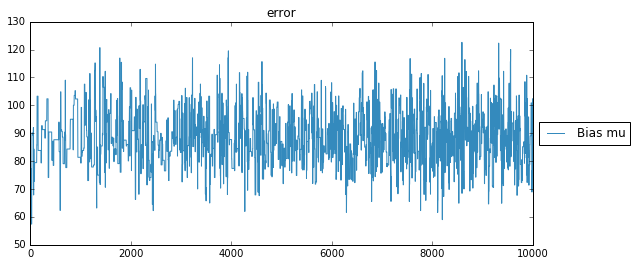

In [156]:
ax = plt.subplot(1,1,1) 
        
e = mcmc_ole[0].trace('error')[:]
print np.mean(e)
plt.plot(e,color="#348ABD",label="Bias mu")
plt.title("error")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width*1.5, box.height])

plt.show()

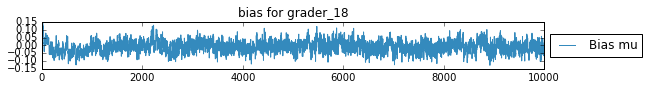

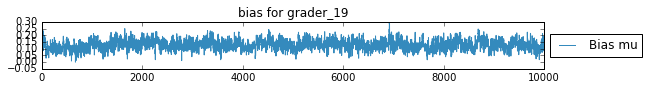

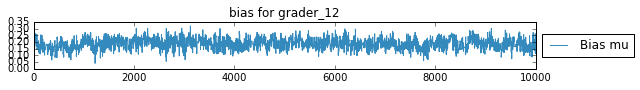

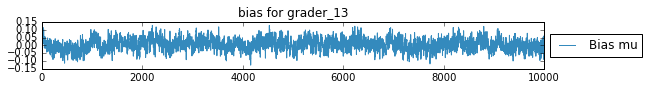

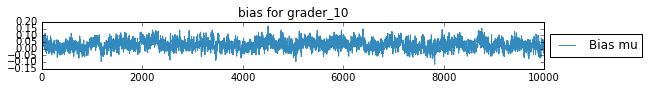

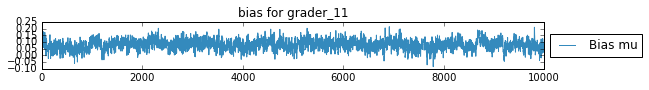

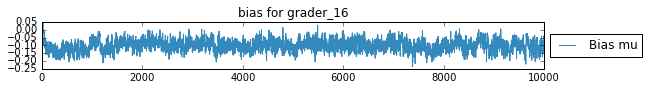

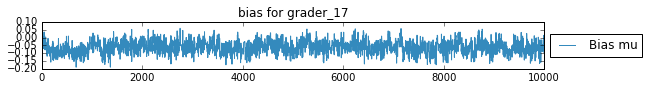

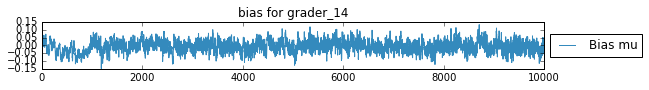

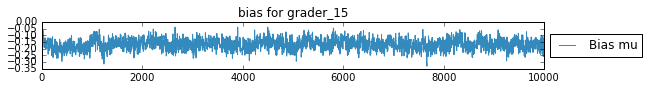

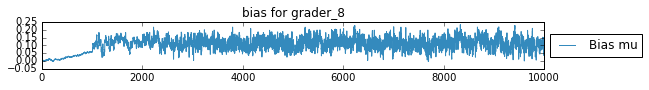

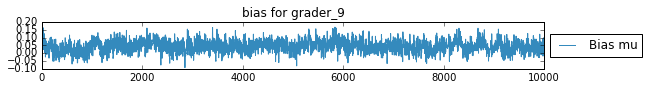

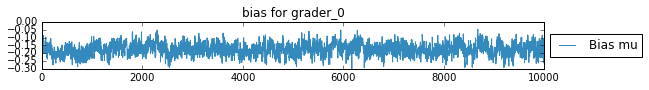

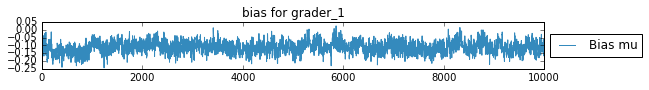

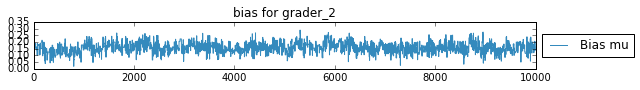

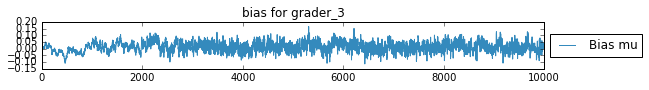

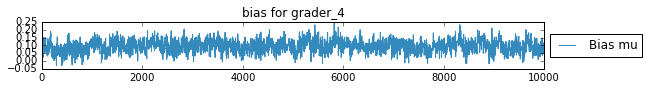

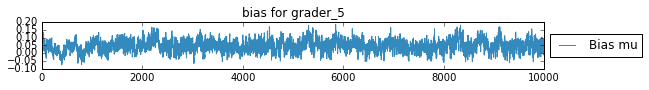

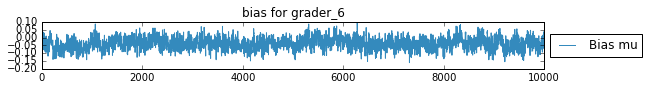

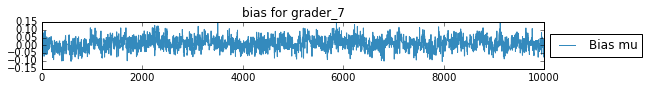

In [150]:
plot_traces_bias(assignment_data_true,mcmc_ole[0])

In [21]:
def plot_traces_handin(assignment,mcmc):
    bias_abs = list()
    for i, g in enumerate(assignment.handins.keys()):
        
        ax = plt.subplot(len(assignment.handins.keys()),1,i+1) 
        
        b_mu = mcmc.trace('T_mu_%s' % str(g))[:]
        b_tau = mcmc.trace('T_tau_%s' % str(g))[:]
        plt.plot(b_mu,color="#348ABD",label="Handin mu")
#        plt.plot(b_tau,color="#A60628",label="Handin tau")
        plt.title("grading for handin %s" % g)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        box = ax.get_position()
        ax.set_position([box.x0, box.y0,
                         box.width*1.5, box.height*5])

        plt.show()

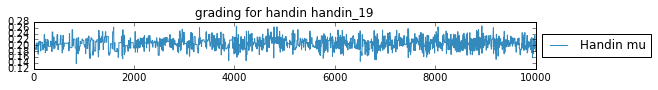

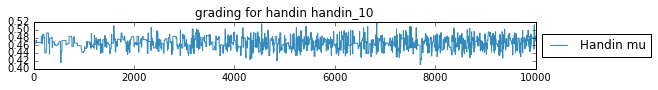

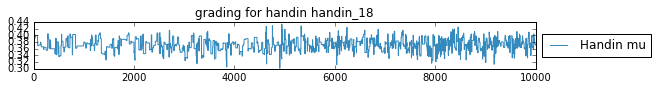

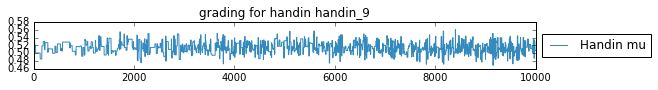

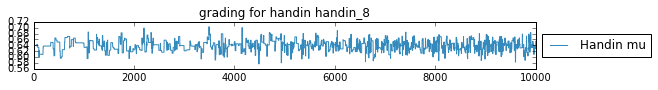

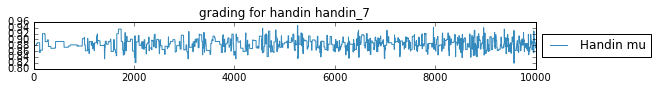

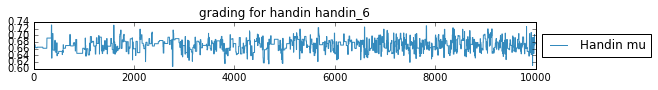

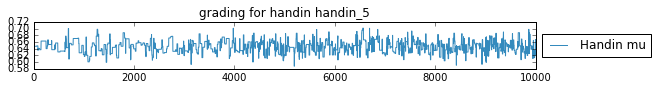

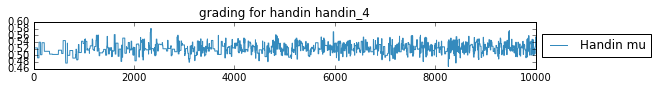

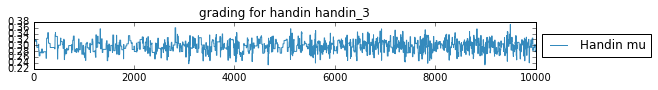

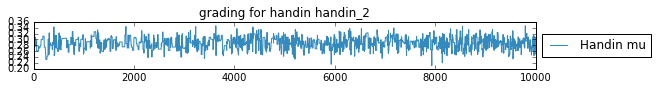

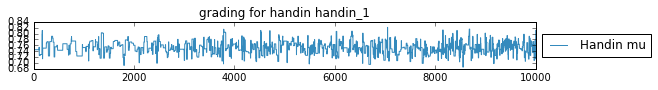

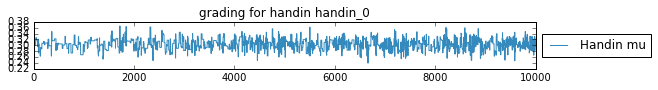

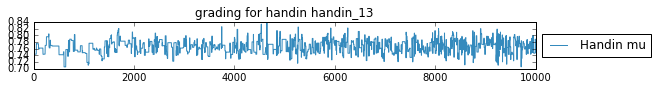

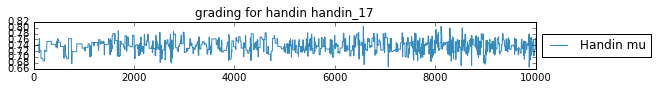

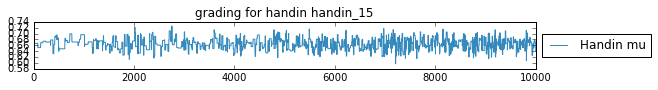

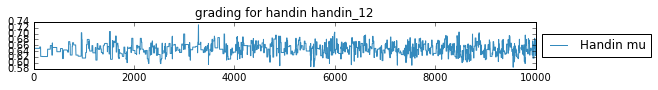

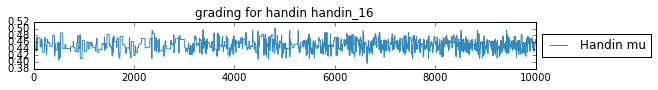

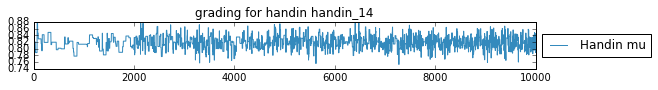

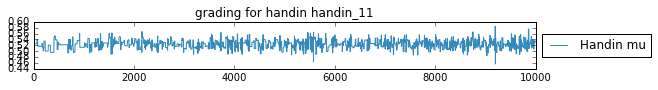

In [90]:
plot_traces_handin(assignment_data_true,mcmc_3[0])

In [23]:
def find_bias(assignment,mcmc,f):
    bias = list()
    for g in assignment.graders.keys():
        value = 0
        if f == 'var':
            value = np.mean(mcmc.trace('B_tau_%s' % str(g))[:])
        elif f == 'mean':
            value = np.mean(mcmc.trace('B_mu_%s' % str(g))[:])
        bias.append((value,g))
    return bias

In [24]:
def find_T(assignment,mcmc,f):
    T = list()
    for h in assignment.handins.keys():
        value = 0
        if f == 'var':
            value = np.mean(mcmc.trace('T_tau_%s' % str(h))[:])
        elif f == 'mean':
            value = np.mean(mcmc.trace('T_mu_%s' % str(h))[:])
        T.append((value,h))
    return T

In [37]:
def compare_to_generated(assignment_data,mcmc_handins,find,func='mean'):
    bias_abs_1 = find(assignment_data, mcmc_handins[0], func)
    bias_abs_2 = find(assignment_data, mcmc_handins[1], func)
    bias_abs_3 = find(assignment_data, mcmc_handins[2], func)

    # Generate dict of the found values in each run for each grader
    compared = defaultdict(list)
    collected = list()
    collected = bias_abs_1[:]
    collected.extend(bias_abs_2[:])
    collected.extend(bias_abs_3[:])

    for (value, _id) in collected:
        compared[_id].append(value)

    sorted_list = list()
    if find.func_name == "find_bias":
        for _id, g in assignment_data.graders.iteritems():
            if func == "mean":
                sorted_list.append((_id,g.bias_mean))
            else:
                sorted_list.append((_id,g.bias_tau))
    else:
        for _id, h in assignment_data.handins.iteritems():
            if func == "mean":
                sorted_list.append((_id,h.true_val))
            else:
                sorted_list.append((_id,h.precision))
            
    sorted_list.sort(key=lambda x: x[1])

    ax = plt.subplot(111)
    
    labels = list()
    true_values = list()
    score_values = list()
    mean_score_values = list()
    MS_val = list()
    y = xrange(0,len(sorted_list))
    for (_id, value) in sorted_list:
        if find.func_name != "find_bias" and func == "mean":
            mean_score = np.mean(assignment_data.handins[_id].gradeings.values())
            mean_score_values.append(mean_score)
        
        MS_val.append(np.mean(compared[_id]))
        score_values.append(compared[_id])
        true_values.append(value)
        labels.append(_id)
    
    MSE_T = 0.0
    MSE_M = sum(map(lambda x : (float(x[1]) - float(x[0])) ** 2,zip(true_values,MS_val))) / len(true_values)
    print MSE_M
    if find.func_name != "find_bias" and func == "mean":
        MSE_T = sum(map(lambda x : (float(x[1]) - float(x[0])) ** 2,zip(true_values,mean_score_values))) / len(true_values)
        print MSE_T
    box_text = ""
    if find.func_name != "find_bias" and func == "mean":
        box_text = 'MSE model: %(h)f\nMSE graded: %(g)f' % {'h': MSE_M, 'g':MSE_T}
    else:
        box_text = "MSE: %f" % MSE_M
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.05, 0.95, box_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    y_ = map(lambda x: [x,x,x],y)
    if find.func_name == "find_bias":
        plt.plot(score_values,y_,'or',label="Pymc found bias",alpha=0.65)
        plt.plot(true_values,y,'ob',label="True bias",alpha=0.65)
    else:
        if func == "mean":
            plt.plot(mean_score_values,y,'og',label="Mean of graded scores",alpha=0.65)
        plt.plot(score_values,y,'or',label="Pymc found handin score",alpha=0.65)
        plt.plot(true_values,y,'ob',label="True handin score",alpha=0.65)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width+0.45, box.height*2])
    plt.yticks(xrange(0,len(sorted_list)),labels)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.99))
    if find.func_name == "find_bias":
        if func == "mean":
            plt.xlabel(r"True graders bias mean compared to the found bias mean through pymc")
        else:
            plt.xlabel(r"True graders bias precision ($\tau$) compared to the found bias precision ($\tau$) through pymc")
        plt.ylabel("Graders")
    else:
        plt.xlabel("True handin score compared to the found handin score through pymc")
        plt.ylabel("Handins")

### MCMC_1

In [ ]:
compare_to_generated(assignment_data_true,mcmc_1,find_bias)

In [ ]:
compare_to_generated(assignment_data_true,mcmc_1,find_T)

### MCMC_2

0.00198201486165


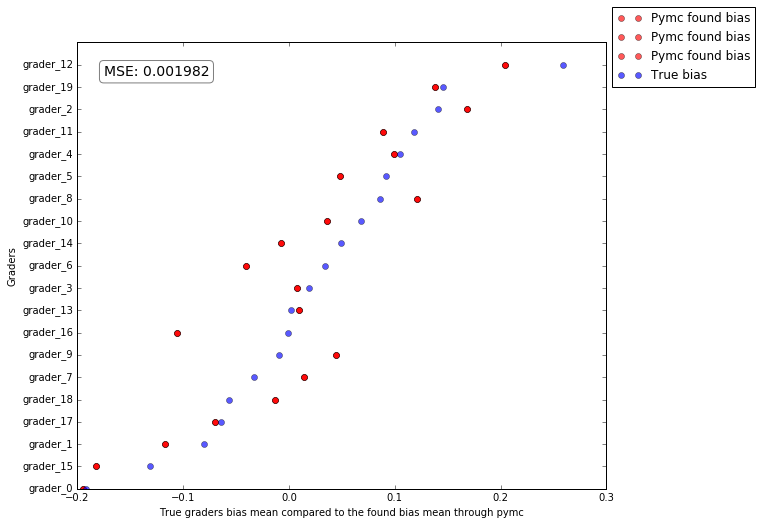

In [97]:
compare_to_generated(assignment_data_true,[mcmc_2[0]]*3,find_bias,'mean')

In [ ]:
compare_to_generated(assignment_data_true,mcmc_2,find_T)

### MCMC_3

In [ ]:
for h in assignment.handins.keys():
    mcmc_3[0].trace('lambda_t_%s' % str(h))[:])

0.00139164022374
0.00114887911287


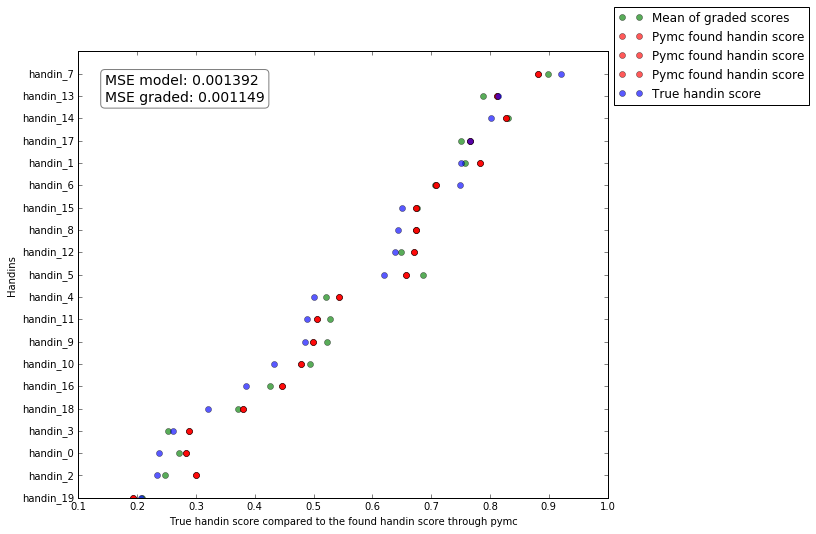

In [117]:
compare_to_generated(assignment_data_true,[mcmc_3[0]]*3,find_T,'mean')

In [ ]:
compare_to_generated(assignment_data_true,mcmc_3,find_T)

### MCMC_4

0.00218608347285


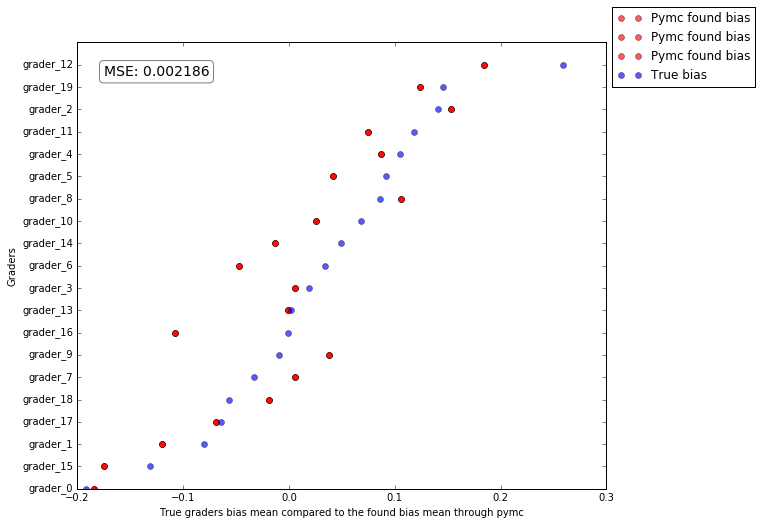

In [77]:
compare_to_generated(assignment_data_true,[mcmc_4[0]]*3,find_bias)

In [ ]:
compare_to_generated(assignment_data_true,[mcmc_4[0]]*3,find_T)

### MCMC_5

0.00188423669518


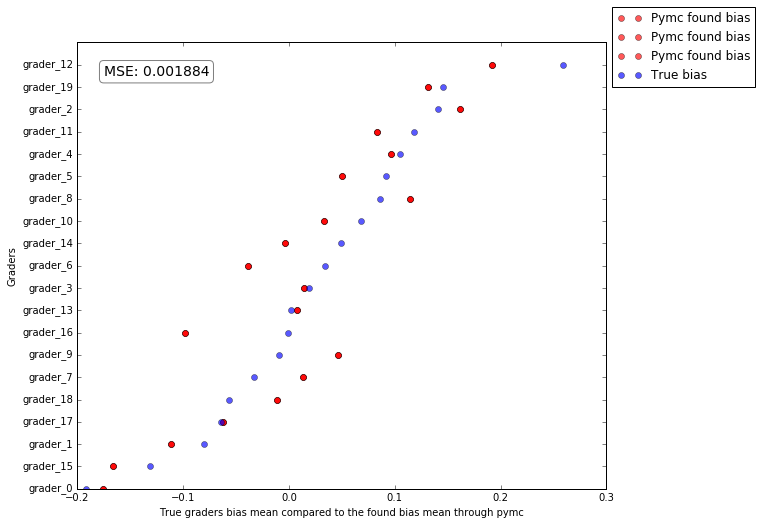

In [78]:
compare_to_generated(assignment_data_true,[mcmc_5[0]]*3,find_bias)

In [ ]:
compare_to_generated(assignment_data_true,[mcmc_5[0]]*3,find_T)

### MCMC_6

0.00176839140434


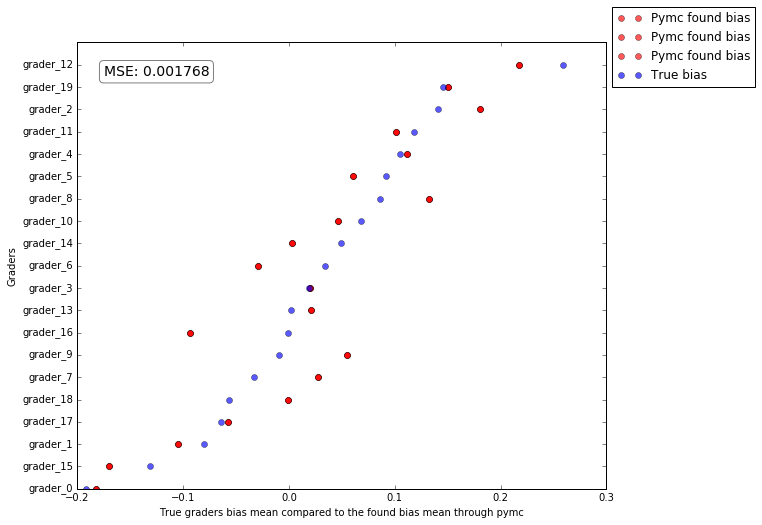

In [79]:
compare_to_generated(assignment_data_true,[mcmc_6[0]]*3,find_bias)

In [ ]:
compare_to_generated(assignment_data_true,mcmc_6,find_T)

### MCMC_7

0.00199099017182


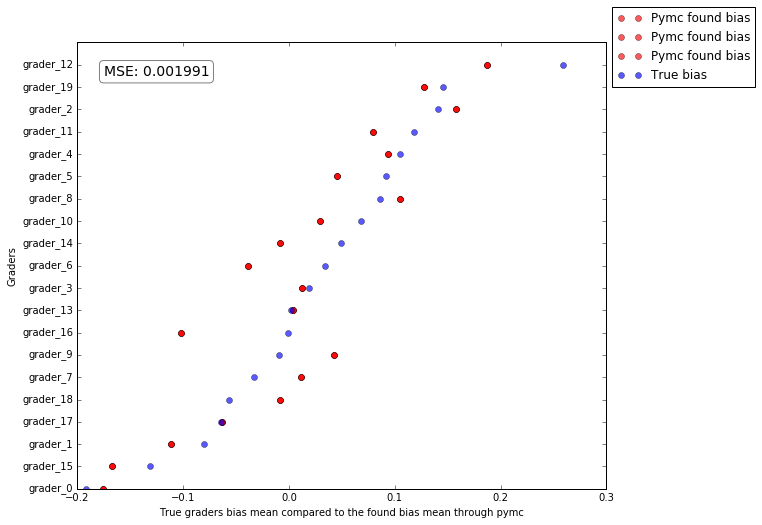

In [157]:
compare_to_generated(assignment_data_true,[mcmc_ole[0]]*3,find_bias,'mean')

### Model Comparison over 5 different data set

The model have been used on 5 different generated data set and then compared against eachother to see if one model is better than the others

In [ ]:
mesured_error = [[(4,0.001756),(1,0.001816),(2,0.001840),(3,0.002005),(6,0.002081),(5,0.002301)],
                 [(2,0.002043),(6,0.002046),(4,0.002279),(1,0.002351),(5,0.002987),(3,0.003079)],
                 [(6,0.001045),(3,0.001053),(4,0.001083),(1,0.001239),(2,0.001284),(5,0.003088)],
                 [(2,0.000934),(3,0.000990),(1,0.001000),(4,0.001183),(6,0.001282),(5,0.002000)],
                 [(4,0.001913),(1,0.002172),(2,0.002586),(3,0.002744),(6,0.003017),(5,0.003726)],
                 [(2,0.001213),(6,0.001242),(4,0.001312),(3,0.001362),(1,0.001644),(5,0.002533)],
                 [(1,0.000791),(6,0.000813),(3,0.000890),(4,0.000918),(2,0.000956),(5,0.001501)]]

In [ ]:

ax = plt.subplot(111)
colors = ['r','b','g','m','c','y']
lines = defaultdict(list)
for set_,data in enumerate(mesured_error):
    for (model,error) in data:
        lines[model].append((set_,error))
    
for model, l in lines.iteritems():
    xs = list()
    ys = list()
    for i in xrange(len(lines)+1):
        (x1,y1) = l[i]
        xs.append(x1+1)
        ys.append(y1)
    
    line = plt.plot(xs,ys,colors[model-1],label="model %i" % model)


box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width*2, box.height*1.5])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("dataset")
plt.ylabel("Mean Square Error")
plt.show()

In [ ]:
pos_m = defaultdict(list)
for set_,data in enumerate(mesured_error):
    for (pos, (model,error)) in enumerate(data):
        pos_m[model].append(pos)
        
for m, pos in pos_m.iteritems():
#    print m, pos
    print "model_" + str(m) + ": mean: " + str(np.mean(pos)) + ", median: " + str(np.median(pos))